In [1]:
from monai.utils import first
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    ToTensord,
    ScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    Flipd,
    RandAffined,
)


from monai.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import os
import torch
import nibabel as nib
from tqdm import tqdm

In [2]:
def save_nifti(in_image, in_label, out, index = 0):
    # Convert the torch tensors into numpy array
    volume = np.array(in_image.detach().cpu()[0, :, :, :], dtype=np.float32)
    lab = np.array(in_label.detach().cpu()[0, :, :, :], dtype=np.float32)
    
    # Convert the numpy array into nifti file
    volume = nib.Nifti1Image(volume, np.eye(4))
    lab = nib.Nifti1Image(lab, np.eye(4))
    
    # Create the path to save the images and labels
    path_out_images = os.path.join(out, 'Images')
    path_out_labels = os.path.join(out, 'Labels')
    
    # Make directory if not existing
    if not os.path.exists(path_out_images):
        os.mkdir(path_out_images)
    if not os.path.exists(path_out_labels):
        os.mkdir(path_out_labels)
    
    path_data = os.path.join(out, 'Images')
    path_label = os.path.join(out, 'Labels')
    nib.save(volume, os.path.join(path_data, f'patient_generated_{index}.nii.gz'))
    nib.save(lab, os.path.join(path_label, f'patient_generated_{index}.nii.gz'))

    print(f'patient_generated_{index} is saved', end='\r')

In [3]:
data_dir = r'C:\Users\abhay\DATASET\Data_Train_Test'
train_images = sorted(glob.glob(os.path.join(data_dir, "TrainVolumes", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "TrainSegmentation", "*.nii.gz")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

In [4]:
original_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=['image'], pixdim=(1.5, 1.5, 2.0), mode=("bilinear")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,), 
        ToTensord(keys=["image", "label"]),
    ]
)

C:\Users\Abhay Tiwari\AppData\Roaming\Python\Python39\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
C:\Users\Abhay Tiwari\AppData\Roaming\Python\Python39\site-packages\monai\utils\deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
C:\Users\Abhay Tiwari\AppData\Roaming\Python\Python39\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta

In [5]:
generat_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,), 
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)                                                                                                                               

In [6]:
original_ds = Dataset(data=train_files, transform=original_transforms)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

_______________________________________________________________________________________________________

# Display the original patient and the generated one

TypeError: 'NoneType' object is not subscriptable

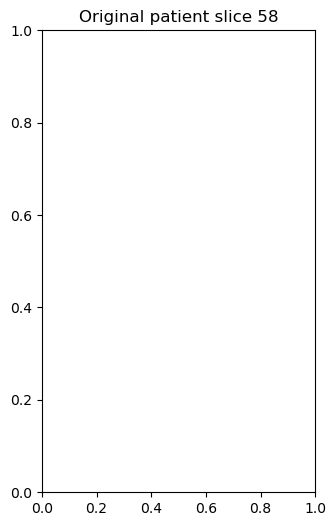

In [7]:
number_slice = 58
plt.figure("display", (12, 6))

plt.subplot(1, 3, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")

plt.subplot(1, 3, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")

plt.subplot(1, 3, 3)
plt.title(f"Generated patient label {number_slice}")
plt.imshow(generat_patient["label"][0, 0, :, :, number_slice])
plt.show()

_______________________________________________________________________________________________________

# Save the generated patients
The variable 'number_runs' will control how many time you will multiply your data.

In [28]:
output_path = r'C:\Users\abhay\DATASET\Data_Train_Test\generated_data'
number_runs = 10
for i in range(number_runs):
    name_folder = 'generated_data_' + str(i)
    os.mkdir(os.path.join(output_path, name_folder))
    output = os.path.join(output_path, name_folder)
    check_ds = Dataset(data=train_files, transform=generat_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    check_data = first(check_loader)
    for index, patient in enumerate(check_loader):
        save_nifti(patient['image'], patient['label'], output, index)
    print(f'step {i} done')

step 0 doneerated_1 is saved
step 1 doneerated_1 is saved
step 2 doneerated_1 is saved
step 3 doneerated_1 is saved
step 4 doneerated_1 is saved
step 5 doneerated_1 is saved
step 6 doneerated_1 is saved
step 7 doneerated_1 is saved
step 8 doneerated_1 is saved
step 9 doneerated_1 is saved
